In [198]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from io import BytesIO
import io
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models
from random import sample
import albumentations as A
from albumentations.pytorch import ToTensorV2
from imblearn.under_sampling import RandomUnderSampler

from tqdm.notebook import tqdm

In [199]:
# Load CSV with Image Location and Labels
train = pd.read_csv('data/train_labels.csv')
test = pd.read_csv('data/test_labels.csv')

In [202]:
# Take Top 8 categories
small_set = list(train['category_name'].value_counts().index[:8])

train = train[train['category_name'].isin(small_set)]
test = test[test['category_name'].isin(small_set)]

#Take a Smaller Sample
train = train.sample(frac = 0.025, random_state=0).reset_index()
test = test.sample(frac = 0.0125, random_state=0).reset_index()

In [203]:
# Prep for Undersampling
y = train.category_name.values
train.drop(columns = ['category_name'], inplace = True)

In [205]:
# Undersample Training to balance classes
undersample = RandomUnderSampler(sampling_strategy='auto', random_state = 0)
train, train_y = undersample.fit_resample(train, y)
train['category_name'] = train_y

In [208]:
train['category_name'].value_counts()

Blouse      276
Cardigan    276
Dress       276
Shorts      276
Skirt       276
Sweater     276
Tank        276
Tee         276
Name: category_name, dtype: int64

In [213]:
# Create Dataset Class
class FashionDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.label_dict = {o:i for i,o in enumerate(np.unique(train.category_name))}
        self.augment = augment
        
        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.HorizontalFlip(p=.25),
                A.VerticalFlip(p=.25),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .375),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.25),
                
                # we will normalize according to ImageNet since we will be using a pre-trained ResNet
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        key = row.image_name.replace('\\','/')

        # Load Image
        img = cv2.imread(key)
        
        # to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # resize img
        img = cv2.resize(img, (224,224))
        
        if self.augment == True:
            #Transform
            transformed = self.transforms(image=img.astype(np.uint8))
            img = transformed['image']
        else:
            #Move Channel to correct spot and convert to float
            img = np.transpose(img, (2,0,1))
            img = torch.tensor(img/255.).float()
              
        label = torch.tensor(self.label_dict[row['category_name']])
        
        return img, label

In [214]:
train_ds = FashionDataset(train, augment=True)
dl_train = DataLoader(train_ds, batch_size=8, shuffle=True)

In [215]:
valid_ds = FashionDataset(test, augment=False)
dl_valid = DataLoader(valid_ds, batch_size=8, shuffle=False)

### Resnet18

In [216]:
# Initiate Model
model = models.resnet18(pretrained=True)

# Freeze Parameters
for param in model.parameters():
    param.requires_grad = False

# Replace Fully Connected Layer Lay
model.fc = nn.Sequential(
    nn.Linear(512, len(train['category_name'].unique()))
)

In [217]:
# Create Training and Eval Functions
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in tqdm(dataloader):
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [218]:
# Train Model
lossFun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

num_epochs = 10
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch+1)
    
    train_loss = one_pass(model, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(model, dl_valid, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(model, dl_train, len(train_ds))
    train_accs.append(train_acc)
    valid_acc = one_pass_acc(model, dl_valid, len(valid_ds))
    valid_accs.append(valid_acc)
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  1


  0%|          | 0/276 [00:00<?, ?it/s]

Train loss:  1.9312866079634514


  0%|          | 0/46 [00:00<?, ?it/s]

Valid loss:  2.005117999470752


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc:  0.4252717391304348
Valid Acc:  0.2237569060773481
Epoch:  2


  0%|          | 0/276 [00:00<?, ?it/s]

Train loss:  1.650443029144536


  0%|          | 0/46 [00:00<?, ?it/s]

Valid loss:  1.9596053595128267


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc:  0.4624094202898551
Valid Acc:  0.3149171270718232
Epoch:  3


  0%|          | 0/276 [00:00<?, ?it/s]

Train loss:  1.5582299329664395


  0%|          | 0/46 [00:00<?, ?it/s]

Valid loss:  1.8459561493085779


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc:  0.5081521739130435
Valid Acc:  0.3342541436464088
Epoch:  4


  0%|          | 0/276 [00:00<?, ?it/s]

Train loss:  1.5302070789579032


  0%|          | 0/46 [00:00<?, ?it/s]

Valid loss:  1.8754265619360881


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc:  0.5280797101449275
Valid Acc:  0.3121546961325967
Epoch:  5


  0%|          | 0/276 [00:00<?, ?it/s]

Train loss:  1.4765051473741946


  0%|          | 0/46 [00:00<?, ?it/s]

Valid loss:  1.872398265030073


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc:  0.5063405797101449
Valid Acc:  0.3287292817679558
Epoch:  6


  0%|          | 0/276 [00:00<?, ?it/s]

Train loss:  1.4888516210991403


  0%|          | 0/46 [00:00<?, ?it/s]

Valid loss:  2.0283128800599473


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc:  0.5153985507246377
Valid Acc:  0.27900552486187846
Epoch:  7


  0%|          | 0/276 [00:00<?, ?it/s]

Train loss:  1.47686826383722


  0%|          | 0/46 [00:00<?, ?it/s]

Valid loss:  1.7260471997053728


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc:  0.5593297101449275
Valid Acc:  0.36187845303867405
Epoch:  8


  0%|          | 0/276 [00:00<?, ?it/s]

Train loss:  1.448889069583105


  0%|          | 0/46 [00:00<?, ?it/s]

Valid loss:  1.5862594480099885


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc:  0.5280797101449275
Valid Acc:  0.40607734806629836
Epoch:  9


  0%|          | 0/276 [00:00<?, ?it/s]

Train loss:  1.4448464543059252


  0%|          | 0/46 [00:00<?, ?it/s]

Valid loss:  1.8068405532318612


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc:  0.5507246376811594
Valid Acc:  0.35635359116022103
Epoch:  10


  0%|          | 0/276 [00:00<?, ?it/s]

Train loss:  1.4325378757456075


  0%|          | 0/46 [00:00<?, ?it/s]

Valid loss:  1.7009488266447317


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Train Acc:  0.5715579710144927
Valid Acc:  0.40055248618784534


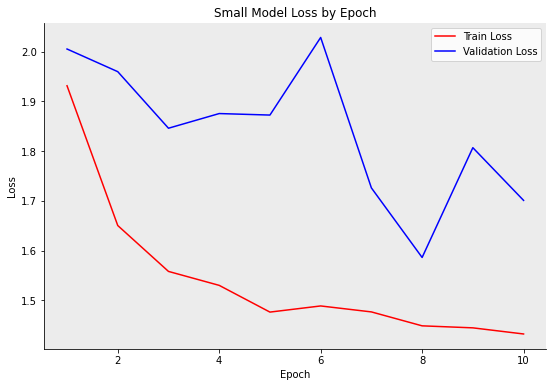

In [223]:
# Graph Loss
x = range(1, 11)

fig, ax = plt.subplots(figsize = (9,6))
ax.plot(x, train_losses, c = 'r', label = 'Train Loss')
ax.plot(x, valid_losses, c = 'b', label = 'Validation Loss')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('#ECECEC')
plt.title('Small Model Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

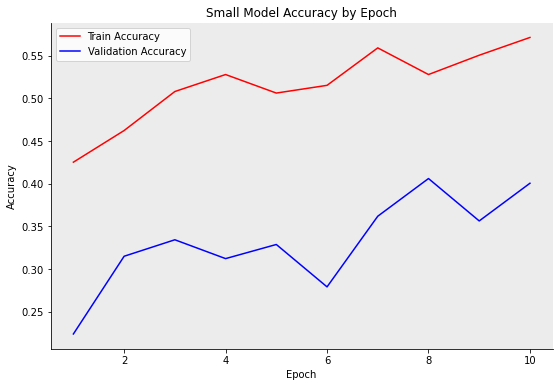

In [224]:
# Graph Accuracy
fig, ax = plt.subplots(figsize = (9,6))
ax.plot(x, train_accs, c = 'r', label = 'Train Accuracy')
ax.plot(x, valid_accs, c = 'b', label = 'Validation Accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('#ECECEC')
plt.title('Small Model Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()